This notebook should only be run locally alongside a set of COMPAS output data.

## Prelude

In [1]:
import pandas as pd
from pathlib import Path
import tables as tb
import numpy as np
import astropy.units as u
from math import isnan
import matplotlib.pyplot as plt

In [2]:
random_state = 42

In [3]:
stellar_types = {'0' : 'MS<0.7',
                 '1' : 'MS>0.7',
                 '2' : 'HG',
                 '3' : 'GB',
                 '4' : 'CHeB',
                 '5' : 'EAGB',
                 '6' : 'TPAGB',
                 '7' : 'HeMS',
                 '8' : 'HeHG',
                 '9' : 'HeGB',
                 '10': 'HeWD',
                 '11': 'COWD',
                 '12': 'ONeWD',
                 '13': 'NS',
                 '14': 'BH',
                 '15': 'massless',
                 '16': '16',
                 '17': '17',
                 '18': '18',
                 '19': '19'}

In [4]:
def chirp_mass(row):
    m1 = row['Mass(1)']
    m2 = row['Mass(2)']
    return (m1*m2)**(3/5)/(m1+m2)**(1/5)

def bintype2(bintype):
    t1, t2 = bintype.split('+')
    return stellar_types[t1]+stellar_types[t2]

def row_to_gridfile(row, filename):
    with open(filename, 'w') as file:
        settings = [int(str(row['SEED'])[:-4]), row['Mass_at_ZAMS_1'], row['Mass_at_ZAMS_2'], row['SemiMajorAxis_at_ZAMS'], row['Metallicity_at_ZAMS_1'], 0]
        line = ''.join([option + str(setting) + ' ' for option,setting in zip(options, settings)])
        file.write(line+'\n')
        
def symmetrized_q(m1,m2):
    if m1 > m2:
        return m2/m1
    else:
        return m1/m2
    
def symmetrize_masses(df):
    if df['Mass(1)'] > df['Mass(2)']:
        return df['Mass(1)'],df['Mass(2)']
    else:
        return df['Mass(2)'],df['Mass(1)']

## Loading data

In [5]:
ROOT = Path('..')
DATA_FOLDER = Path(ROOT, 'Data')

# remember to set data file paths accordingly
OUTPUT_FOLDER1 = Path(DATA_FOLDER, 'IMFgrid2_results')
OUTPUT_FOLDER2 = Path(DATA_FOLDER, 'IMFgrid3_results')

output_paths = list(OUTPUT_FOLDER1.glob('COMPAS_Output*/COMPAS_Output.h5'))+list(OUTPUT_FOLDER2.glob('COMPAS_Output*/COMPAS_Output.h5'))
label_paths = list(OUTPUT_FOLDER1.glob('COMPAS_Output*/compas_grid*.txt'))+list(OUTPUT_FOLDER2.glob('COMPAS_Output*/compas_grid*.txt'))

In [6]:
DCOtable_columns_to_load = ['SEED', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SemiMajorAxis@DCO', 'Eccentricity@DCO', 'Coalescence_Time']
SysParam_table_columns_to_load = ['CE_Alpha', 'Eccentricity@ZAMS', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'SemiMajorAxis@ZAMS', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Metallicity@ZAMS(1)', 'Metallicity@ZAMS(2)']
SNtable_columns_to_load = ['Supernova_State', 'Mass_Core@CO(SN)', 'Mass_He_Core@CO(SN)', 'Mass_CO_Core@CO(SN)', 'Mass(SN)', 'Experienced_RLOF(SN)','Mass(CP)', 'SemiMajorAxis', 'SemiMajorAxis<SN', 'Stellar_Type(CP)', 'Stellar_Type_Prev(SN)', 'Stellar_Type(SN)']

In [7]:
catalog = {}

for path, label in zip(output_paths, label_paths):
    print(f'Now loading {path}')
    
    table = tb.open_file(path, 'r')
    
    if not table.root.__contains__('BSE_System_Parameters'):
        print(f'Output {path} seems to be broken.')
        print('')
        continue
    
    z = label.stem.split('_')[2].lstrip('z')
    Z = label.stem.split('_')[3].lstrip('Z')
    
    partial_catalog = {}
    
    DCOtable = table.root.BSE_Double_Compact_Objects
    SNtable = table.root.BSE_Supernovae
    SysParam_table = table.root.BSE_System_Parameters
    
    seeds = list(DCOtable.SEED)
    N = len(seeds)

    print('Loading Double Compact Objects table...')
    for i, seed in enumerate(DCOtable.SEED):
        if seed in seeds:
            for column in DCOtable_columns_to_load:
                if column not in partial_catalog:
                    partial_catalog[column] = np.zeros(N,)
                partial_catalog[column][i] = DCOtable[column][i]
            
    print('Loading System Parameters table...')
    for i, seed in enumerate(SysParam_table.SEED):
        if seed in seeds:
            index = seeds.index(seed)
            for column in SysParam_table_columns_to_load:
                if column not in partial_catalog:
                    partial_catalog[column] = np.zeros(N,)
                partial_catalog[column][index] = SysParam_table[column][i]
    
    print('Loading Supernovae table...')
    for i, seed in enumerate(SNtable.SEED):
        if seed in seeds:
            index = seeds.index(seed)
            for column in SNtable_columns_to_load:
                if column not in partial_catalog:
                    partial_catalog[column] = np.zeros(N,)
                partial_catalog[column][index] = SNtable[column][i]
    
    table.close()
    
    
    print('Fixing seeds...')
    partial_catalog['redshift'] = []
    for index, seed in enumerate(partial_catalog['SEED']):
        new_seed = int(str(int(seed)) + '00' + Z + '00' + z)
        partial_catalog['SEED'][index] = new_seed
        partial_catalog['redshift'].append(int(z)/100)
        
    for item in partial_catalog:
        if item not in catalog:
            catalog[item] = []
        catalog[item] += list(partial_catalog[item])
    print('Done.')
    print('')
    
print('Table loaded.')

Now loading ..\Data\IMFgrid2_results\COMPAS_Output\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_1\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_10\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_11\COMPAS_Output.h5
Output ..\Data\IMFgrid2_results\COMPAS_Output_11\COMPAS_Output.h5 seems to be broken.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_12\COMPAS_Output.h5
Loading Double Compact Objects table...
Loading System Parameters table...
Loading Supernovae table...
Fixing seeds...
Done.

Now loading ..\Data\IMFgrid2_results\COMPAS_Output_13\COMP

#### Dataframe setup

In [8]:
catalog_df = pd.DataFrame(catalog)

In [9]:
for index, row in catalog_df.iterrows():
    m1 = row['Mass(1)']
    m2 = row['Mass(2)']
    if m1 < m2:
        catalog_df.loc[index, 'Mass(1)'] = m2
        catalog_df.loc[index, 'Mass(2)'] = m1

In [10]:
catalog_df['Stellar_Type(1)'] = catalog_df['Stellar_Type(1)'].apply(int)
catalog_df['Stellar_Type(2)'] = catalog_df['Stellar_Type(2)'].apply(int)
catalog_df['Binary_Type'] = (catalog_df['Stellar_Type(1)'].apply(str)+'+'+ catalog_df['Stellar_Type(2)'].apply(str)).apply(bintype2)
catalog_df['Chirp_Mass'] = catalog_df.apply(chirp_mass, axis=1)
catalog_df['Total_Mass@ZAMS'] = catalog_df['Mass@ZAMS(1)']+catalog_df['Mass@ZAMS(2)']
catalog_df['Total_Mass@DCO'] = catalog_df['Mass(1)']+catalog_df['Mass(2)']
catalog_df['SemiMajorAxis@DCO'] = u.au.to(u.Rsun)*catalog_df['SemiMajorAxis@DCO'] # Rsun
catalog_df['SemiMajorAxis@ZAMS'] = u.au.to(u.Rsun)*catalog_df['SemiMajorAxis@ZAMS'] # Rsun
catalog_df['Mass_Ratio@DCO'] = catalog_df.apply(lambda x: symmetrized_q(x['Mass(1)'], x['Mass(2)']), axis=1)
catalog_df['Mass_Ratio@ZAMS'] = catalog_df['Mass@ZAMS(2)']/catalog_df['Mass@ZAMS(1)']
catalog_df['Coalescence_Time'] = 1e6*catalog_df['Coalescence_Time'] # time in years
catalog_df['SEED'] = catalog_df['SEED'].apply(int)

In [11]:
catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22597 entries, 0 to 22596
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   SEED                   22597 non-null  uint64 
 1   Mass(1)                22597 non-null  float64
 2   Mass(2)                22597 non-null  float64
 3   Merges_Hubble_Time     22597 non-null  float64
 4   Stellar_Type(1)        22597 non-null  int64  
 5   Stellar_Type(2)        22597 non-null  int64  
 6   Recycled_NS(1)         22597 non-null  float64
 7   Recycled_NS(2)         22597 non-null  float64
 8   SemiMajorAxis@DCO      22597 non-null  float64
 9   Eccentricity@DCO       22597 non-null  float64
 10  Coalescence_Time       22597 non-null  float64
 11  CE_Alpha               22597 non-null  float64
 12  Eccentricity@ZAMS      22597 non-null  float64
 13  Mass@ZAMS(1)           22597 non-null  float64
 14  Mass@ZAMS(2)           22597 non-null  float64
 15  Se

In [12]:
catalog_df.describe()

,SEED,Mass(1),Mass(2),Merges_Hubble_Time,Stellar_Type(1),Stellar_Type(2),Recycled_NS(1),Recycled_NS(2),SemiMajorAxis@DCO,Eccentricity@DCO,...,SemiMajorAxis<SN,Stellar_Type(CP),Stellar_Type_Prev(SN),Stellar_Type(SN),redshift,Chirp_Mass,Total_Mass@ZAMS,Total_Mass@DCO,Mass_Ratio@DCO,Mass_Ratio@ZAMS
count,2.259700e+04,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,2.259700e+04,22597.000000,...,2.259700e+04,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000,22597.000000
mean,2.304214e+18,13.766566,10.382250,0.313227,13.633580,13.595610,0.272780,0.036288,6.121307e+04,0.270969,...,5.127833e+04,13.643183,9.281276,13.586007,1.000521,10.154606,78.912942,24.148816,0.798081,0.740832
std,4.838654e+18,11.808161,9.918775,0.463816,0.481837,0.490784,0.445398,0.187010,4.472797e+05,0.308102,...,1.345921e+05,0.479071,2.193004,0.492558,0.565480,9.141687,61.236896,21.157135,0.257478,0.192470
min,1.639654e+15,1.260000,1.260000,0.000000,13.000000,13.000000,0.000000,0.000000,7.916856e-02,0.000004,...,6.715433e-02,13.000000,5.000000,13.000000,0.010000,1.096894,9.104137,2.520000,0.028319,0.032469
25%,1.639430e+17,1.260240,1.260000,0.000000,13.000000,13.000000,0.000000,0.000000,9.067948e+00,0.003509,...,4.905895e+00,13.000000,8.000000,13.000000,0.610000,1.096998,17.701539,2.520240,0.662786,0.627636
50%,1.639723e+17,14.870794,8.037318,0.000000,14.000000,14.000000,0.000000,0.000000,5.941645e+01,0.148894,...,3.167284e+01,14.000000,8.000000,14.000000,1.000000,9.510499,71.479717,24.769052,0.924357,0.762695
75%,1.639449e+18,22.101827,16.813219,1.000000,14.000000,14.000000,1.000000,0.000000,2.524046e+04,0.492310,...,2.388717e+04,14.000000,12.000000,14.000000,1.400000,16.745117,117.702048,39.083311,0.999899,0.900965
max,1.639529e+19,144.262443,43.827681,1.000000,14.000000,14.000000,1.000000,1.000000,4.069097e+07,0.999929,...,3.077077e+06,14.000000,12.000000,14.000000,1.800000,38.154213,287.091346,150.258862,1.000000,1.000000


#### All binaries

In [13]:
redshifts = np.unique(np.array(catalog_df['redshift']))
metallicities = np.unique(np.array(catalog_df['Metallicity@ZAMS(1)']))

In [14]:
BHBH_df = catalog_df[(catalog_df['Stellar_Type(1)']==14) & (catalog_df['Stellar_Type(2)']==14)]
BHNS_df = catalog_df[(catalog_df['Stellar_Type(1)']==14) & (catalog_df['Stellar_Type(2)']==13)]
NSBH_df = catalog_df[(catalog_df['Stellar_Type(1)']==13) & (catalog_df['Stellar_Type(2)']==14)]
NSNS_df = catalog_df[(catalog_df['Stellar_Type(1)']==13) & (catalog_df['Stellar_Type(2)']==13)]
agnostic_BHNS_df = catalog_df[np.logical_or(
                                            np.logical_and(catalog_df['Stellar_Type(1)']==14, catalog_df['Stellar_Type(2)']==13),
                                            np.logical_and(catalog_df['Stellar_Type(1)']==13, catalog_df['Stellar_Type(2)']==14)
                                            )
                             ]

BHBH_df.reset_index(drop=True, inplace=True)
BHNS_df.reset_index(drop=True, inplace=True)
NSBH_df.reset_index(drop=True, inplace=True)
NSNS_df.reset_index(drop=True, inplace=True)
agnostic_BHNS_df.reset_index(drop=True, inplace=True)

#### Merging binaries

In [15]:
mBHBH_df = BHBH_df[(BHBH_df['Merges_Hubble_Time']==1)]
mBHNS_df = BHNS_df[(BHNS_df['Merges_Hubble_Time']==1)]
mNSBH_df = NSBH_df[(NSBH_df['Merges_Hubble_Time']==1)]
mNSNS_df = NSNS_df[(NSNS_df['Merges_Hubble_Time']==1)]
agnostic_mBHNS_df = agnostic_BHNS_df[(agnostic_BHNS_df['Merges_Hubble_Time']==1)]

In [16]:
mcatalog_df = catalog_df[(catalog_df['Merges_Hubble_Time']==1)]

## Saving the data

In [51]:
ROOT = Path('.', 'ClassifierOutput')

In [52]:
filepath = Path(ROOT, 'BHBH_catalog.txt')

mBHBH_df.reset_index(drop=True, inplace=True)
df = mBHBH_df[['SEED', 'Mass(1)', 'Mass(2)', 'Total_Mass@DCO', 'Chirp_Mass', 'redshift']]
df.to_csv(filepath, index=True, header='True', sep=' ')

In [53]:
filepath = Path(ROOT, 'BHNS_catalog.txt')

agnostic_mBHNS_df.reset_index(drop=True, inplace=True)
df = agnostic_mBHNS_df[['SEED', 'Mass(1)', 'Mass(2)', 'Total_Mass@DCO', 'Chirp_Mass', 'redshift']]
df.to_csv(filepath, index=True, header='True', sep=' ')

In [54]:
filepath = Path(ROOT, 'NSNS_catalog.txt')

mNSNS_df.reset_index(drop=True, inplace=True)
df = mNSNS_df[['SEED', 'Mass(1)', 'Mass(2)', 'Total_Mass@DCO', 'Chirp_Mass', 'redshift']]
df.to_csv(filepath, index=True, header='True', sep=' ')

## Sorting the data

In [55]:
HEADER = 'SEED M1 M2 M_total M_chirp Redshift'

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


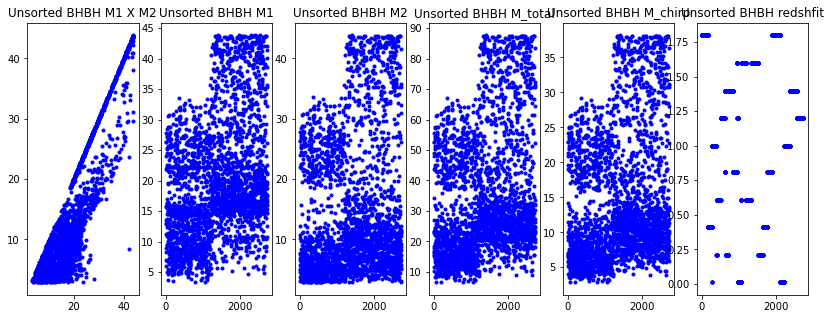

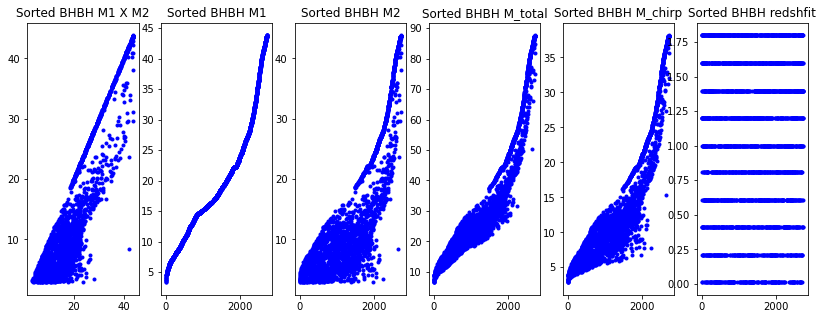

In [56]:
FILE = Path(ROOT, 'BHBH_catalog.txt')

index, seed_unsorted, m1_unsorted, m2_unsorted, m_total_unsorted, m_chirp_unsorted, redshift_unsorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_unsorted, m2_unsorted, 'b.')
ax1.set_title('Unsorted BHBH M1 X M2')
ax2.plot(m1_unsorted, 'b.')
ax2.set_title('Unsorted BHBH M1')
ax3.plot(m2_unsorted, 'b.')
ax3.set_title('Unsorted BHBH M2')
ax4.plot(m_total_unsorted, 'b.')
ax4.set_title('Unsorted BHBH M_total')
ax5.plot(m_chirp_unsorted, 'b.')
ax5.set_title('Unsorted BHBH M_chirp')
ax6.plot(redshift_unsorted, 'b.')
ax6.set_title('Unsorted BHBH redshfit')

fig.show()

sorted_m1_indexes = np.argsort(m1_unsorted)
seed_sorted = np.array([seed_unsorted[index] for index in sorted_m1_indexes])
m1_sorted = np.array([m1_unsorted[index] for index in sorted_m1_indexes])
m2_sorted = np.array([m2_unsorted[index] for index in sorted_m1_indexes])
m_total_sorted = np.array([m_total_unsorted[index] for index in sorted_m1_indexes])
m_chirp_sorted = np.array([m_chirp_unsorted[index] for index in sorted_m1_indexes])
redshift_sorted = np.array([redshift_unsorted[index] for index in sorted_m1_indexes])

sorted_array = np.array([index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted]).T

np.savetxt(FILE, sorted_array, header=HEADER, delimiter=' ')

index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_sorted, m2_sorted, 'b.')
ax1.set_title('Sorted BHBH M1 X M2')
ax2.plot(m1_sorted, 'b.')
ax2.set_title('Sorted BHBH M1')
ax3.plot(m2_sorted, 'b.')
ax3.set_title('Sorted BHBH M2')
ax4.plot(m_total_sorted, 'b.')
ax4.set_title('Sorted BHBH M_total')
ax5.plot(m_chirp_sorted, 'b.')
ax5.set_title('Sorted BHBH M_chirp')
ax6.plot(redshift_sorted, 'b.')
ax6.set_title('Sorted BHBH redshfit')

fig.show()

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


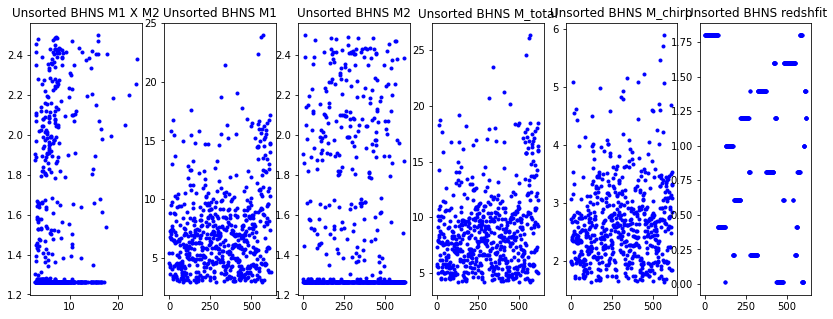

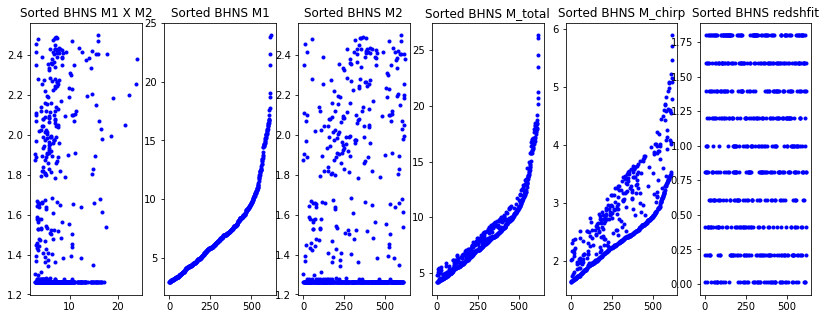

In [57]:
FILE = Path(ROOT, 'BHNS_catalog.txt')

index, seed_unsorted, m1_unsorted, m2_unsorted, m_total_unsorted, m_chirp_unsorted, redshift_unsorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_unsorted, m2_unsorted, 'b.')
ax1.set_title('Unsorted BHNS M1 X M2')
ax2.plot(m1_unsorted, 'b.')
ax2.set_title('Unsorted BHNS M1')
ax3.plot(m2_unsorted, 'b.')
ax3.set_title('Unsorted BHNS M2')
ax4.plot(m_total_unsorted, 'b.')
ax4.set_title('Unsorted BHNS M_total')
ax5.plot(m_chirp_unsorted, 'b.')
ax5.set_title('Unsorted BHNS M_chirp')
ax6.plot(redshift_unsorted, 'b.')
ax6.set_title('Unsorted BHNS redshfit')

fig.show()

sorted_m1_indexes = np.argsort(m1_unsorted)
seed_sorted = np.array([seed_unsorted[index] for index in sorted_m1_indexes])
m1_sorted = np.array([m1_unsorted[index] for index in sorted_m1_indexes])
m2_sorted = np.array([m2_unsorted[index] for index in sorted_m1_indexes])
m_total_sorted = np.array([m_total_unsorted[index] for index in sorted_m1_indexes])
m_chirp_sorted = np.array([m_chirp_unsorted[index] for index in sorted_m1_indexes])
redshift_sorted = np.array([redshift_unsorted[index] for index in sorted_m1_indexes])

sorted_array = np.array([index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted]).T

np.savetxt(FILE, sorted_array, header=HEADER, delimiter=' ')

index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_sorted, m2_sorted, 'b.')
ax1.set_title('Sorted BHNS M1 X M2')
ax2.plot(m1_sorted, 'b.')
ax2.set_title('Sorted BHNS M1')
ax3.plot(m2_sorted, 'b.')
ax3.set_title('Sorted BHNS M2')
ax4.plot(m_total_sorted, 'b.')
ax4.set_title('Sorted BHNS M_total')
ax5.plot(m_chirp_sorted, 'b.')
ax5.set_title('Sorted BHNS M_chirp')
ax6.plot(redshift_sorted, 'b.')
ax6.set_title('Sorted BHNS redshfit')

fig.show()

C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
C:\Users\Lucas\.conda\envs\BCOClass_Py310\lib\site-packages\ipykernel_launcher.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


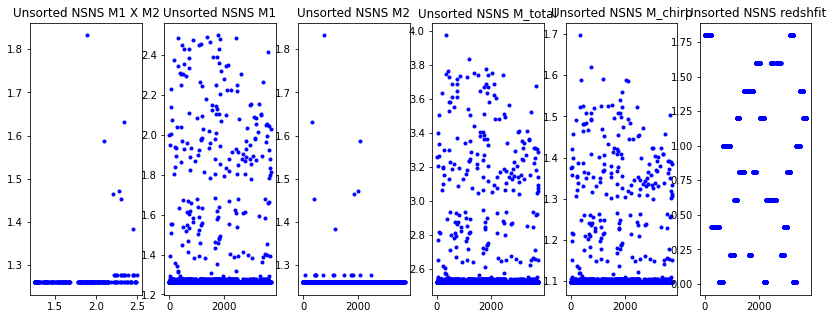

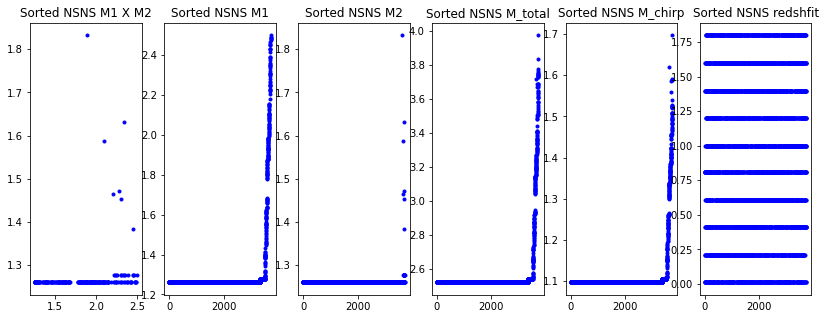

In [58]:
FILE = Path(ROOT, 'NSNS_catalog.txt')

index, seed_unsorted, m1_unsorted, m2_unsorted, m_total_unsorted, m_chirp_unsorted, redshift_unsorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_unsorted, m2_unsorted, 'b.')
ax1.set_title('Unsorted NSNS M1 X M2')
ax2.plot(m1_unsorted, 'b.')
ax2.set_title('Unsorted NSNS M1')
ax3.plot(m2_unsorted, 'b.')
ax3.set_title('Unsorted NSNS M2')
ax4.plot(m_total_unsorted, 'b.')
ax4.set_title('Unsorted NSNS M_total')
ax5.plot(m_chirp_unsorted, 'b.')
ax5.set_title('Unsorted NSNS M_chirp')
ax6.plot(redshift_unsorted, 'b.')
ax6.set_title('Unsorted NSNS redshfit')

fig.show()

sorted_m1_indexes = np.argsort(m1_unsorted)
seed_sorted = np.array([seed_unsorted[index] for index in sorted_m1_indexes])
m1_sorted = np.array([m1_unsorted[index] for index in sorted_m1_indexes])
m2_sorted = np.array([m2_unsorted[index] for index in sorted_m1_indexes])
m_total_sorted = np.array([m_total_unsorted[index] for index in sorted_m1_indexes])
m_chirp_sorted = np.array([m_chirp_unsorted[index] for index in sorted_m1_indexes])
redshift_sorted = np.array([redshift_unsorted[index] for index in sorted_m1_indexes])

sorted_array = np.array([index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted]).T

np.savetxt(FILE, sorted_array, header=HEADER, delimiter=' ')

index, seed_sorted, m1_sorted, m2_sorted, m_total_sorted, m_chirp_sorted, redshift_sorted = np.loadtxt(FILE, unpack=True, skiprows=1)

fig, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(1, 6, figsize=(14,5))

ax1.plot(m1_sorted, m2_sorted, 'b.')
ax1.set_title('Sorted NSNS M1 X M2')
ax2.plot(m1_sorted, 'b.')
ax2.set_title('Sorted NSNS M1')
ax3.plot(m2_sorted, 'b.')
ax3.set_title('Sorted NSNS M2')
ax4.plot(m_total_sorted, 'b.')
ax4.set_title('Sorted NSNS M_total')
ax5.plot(m_chirp_sorted, 'b.')
ax5.set_title('Sorted NSNS M_chirp')
ax6.plot(redshift_sorted, 'b.')
ax6.set_title('Sorted NSNS redshfit')

fig.show()